# Redes Neurais Convolucionais - parte 2

In [1]:
%pylab inline

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

plt.rcParams['image.cmap'] = 'gray_r'

A única diferença real entre o código da classe criada na parte 1 em relação a este da parte 2 é a adição de 2 camadas lineares.

Aproveitei a reescrita para usar um outro objeto do módulo `nn`, o `nn.Sequential` tem um nome verdadeiramente óbvio, a idéia é juntar processos para tornar a função `forward` mais limpa e com menos cara de lisp*

Na função `forward`, adicioneu 3 linhas de código: uma que redimensiona a saída da fase convolucional para que agora ele seja um vetor, e as duas linhas responsáveis de fato pela classificação que usam funções lineares.

Algo que fiquei em dúvida na 1ª vez que implementei foi o valor que eu tinha de colocar na entrada da primeira camada linear, este vídeo, bem no finalzinho, nos ~ 2 minutos finais, dá uma dica que usei para saber que valor colocar: https://www.youtube.com/watch?v=LgFNRIFxuUo

\* código com cara de lisp ---> `(f4(f3(f2(f1()))))`

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Sequential(
                                nn.Conv2d(1, 16, kernel_size=5, stride=1),
                                nn.ReLU()
                            )
        self.conv2 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=5, stride=2),
                                nn.ReLU()
                            )
        
        self.mp = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(128, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.mp(self.conv1(x))
        x = self.mp(self.conv2(x))
        
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x      


In [4]:
convnet = ConvNet()

## lendo o dataset

Algumas particularidades do torchvision:

### trasnforms

Podemos fazer um pré-processamento dos dados de entrada, aqui apenas defini para converter o tipo dos dados lidos em tensores do pytorch, mas é possível redimensionar as imagens, converter para escala de cinza, ler como imagem aberta pelo PIL e mais algumas coisas, porém para um pré-processamento de verdade (usando filtros em outro padrão de cores como o CMYK para ressaltar aspectos da imagem por exemplo) é bem melhor criar um script próprio e depois converter de array para tensor.

### blocos e iteráveis

O maior problema de trabalhar com grandes datasets ou datasets compostos por matrizes de tamanho razoável é o consumo de RAM ser bem elevado, por isso podemos definir a leitura do dataset em blocos indicando o tamanho de cada bloco ("batch_size"), no caso defini que para o treinamento cada bloco terá 300 imagens e para testes apenas 30.

Para ler cada bloco precisamos usar a função builtin `iter`, a cada iteração o objeto devolve 2 tensores: um contendo a matriz que representa as imagens e outro com os valores cujas imagens representam.

In [5]:
trans = transforms.Compose([transforms.ToTensor()])

data_path = "../../images_art/images/mnist/"
data = torchvision.datasets.MNIST(data_path, transform=trans) # download=True)

batch_size = 30
train = DataLoader(dataset=data, batch_size=batch_size*10, shuffle=True)
test = DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

In [6]:
frag_iter = iter(test)
frag = frag_iter.next() # um fragmento do dataset

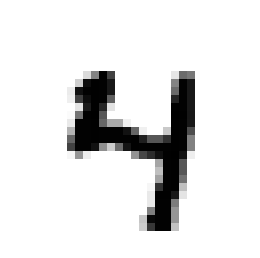

In [64]:
index = 3

matshow(frag[0][index].view(28, 28).detach().numpy()) # dando uma olhada na entrada

In [8]:
out = convnet(frag[0])

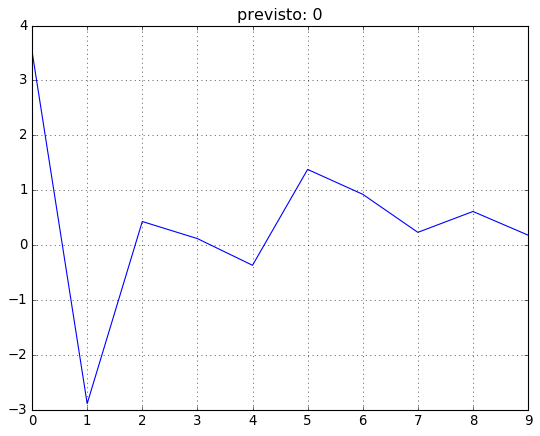

In [85]:
plot(out[0].detach().numpy())
plt.grid(True)
plt.xticks(list(range(10)))
plt.title("previsto: {}".format(out[0].argmax().item()));

In [10]:
learning_rate = 1e-5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnet.parameters(), lr=learning_rate)

In [11]:
%%time
epochs = 15

loss_items = []

for epoch in range(epochs):
    
    for images, labels in train:
        outs = convnet(images)
        loss = criterion(outs, labels)
        loss_items.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # verificando o percentual de acerto
    frag = frag_iter.next() # bloco só de 30 imagens
    res = np.array([i.argmax().item() for i in convnet(frag[0])])
    target = np.array([i.item() for i in frag[1]])
    c = 0
    for i in res - target:
        if i == 0:
            c+=1
    perc = c/len(res)*100
    print(f'epoch: {epoch:<3} | loss: {loss.item():.5f} | acerto: {perc:.3f}%')

epoch: 0   | loss: 2.29334 | acerto: 10.000%
epoch: 1   | loss: 2.27236 | acerto: 20.000%
epoch: 2   | loss: 2.24257 | acerto: 30.000%
epoch: 3   | loss: 2.19670 | acerto: 50.000%
epoch: 4   | loss: 2.13397 | acerto: 40.000%
epoch: 5   | loss: 2.02615 | acerto: 56.667%
epoch: 6   | loss: 1.94034 | acerto: 63.333%
epoch: 7   | loss: 1.75202 | acerto: 63.333%
epoch: 8   | loss: 1.67915 | acerto: 70.000%
epoch: 9   | loss: 1.48669 | acerto: 76.667%
epoch: 10  | loss: 1.34233 | acerto: 76.667%
epoch: 11  | loss: 1.27690 | acerto: 70.000%
epoch: 12  | loss: 1.19124 | acerto: 80.000%
epoch: 13  | loss: 1.03606 | acerto: 76.667%
epoch: 14  | loss: 0.93461 | acerto: 90.000%
CPU times: user 1h 5min 49s, sys: 1min 17s, total: 1h 7min 7s
Wall time: 59min 45s


#### Obs:
O percentual de acerto varia tanto por usar uma dataset de teste pequeno, composto de valores aleatórios e justamente por ser pequeno tende a ter variações maiores, mas ainda assim vemos com clareza o progresso do treinamento.

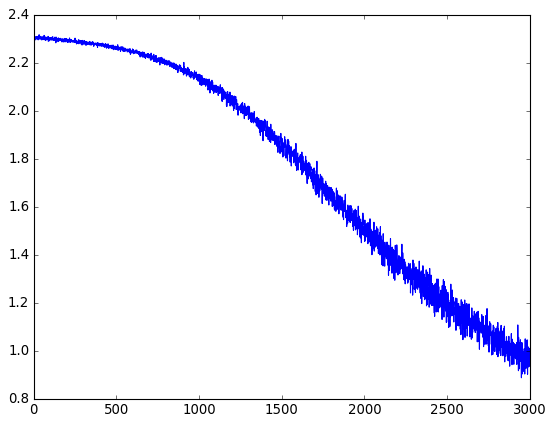

In [82]:
plot(loss_items)

In [52]:
frag = frag_iter.next()

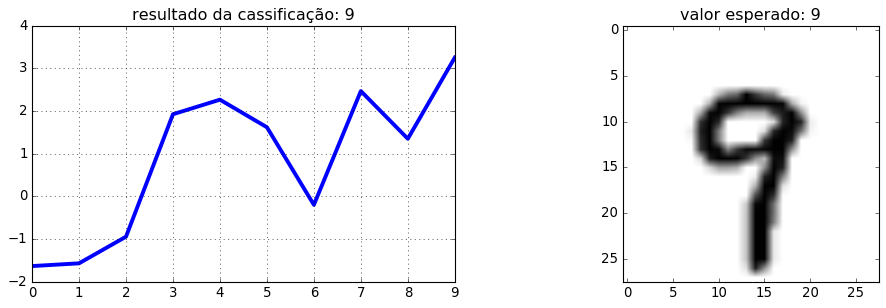

In [81]:
ind = 16

out = convnet(frag[0])

fig, (ax1, ax2) = subplots(1, 2, figsize=(15, 4))

ax1.plot(out[ind].detach().numpy(), linewidth=3.5)
ax1.set_title("resultado da cassificação: {}".format(out[ind].argmax().item()))
ax1.grid(True)
ax1.set_xticks(list(range(10)))

ax2.imshow(frag[0][ind].view(28, 28).detach().numpy())
ax2.set_title("valor esperado: {}".format(frag[1][ind].item()));

Poderíamos considerar o gráfico acima como uma representação de similaridade, como se dizesse que o formato do número "9" é parecido com o número "7" e "4" e nada parecido com o "0", mas essa semelhança é relativa à transformação em vetor daquela matriz resultante da ultima aplicação do maxpool.

In [61]:
res = np.array([i.argmax().item() for i in out])
target = np.array([i.item() for i in frag[1]])

c = 0
for i in res - target:
    if i == 0:
        c+=1
print(f'acerto para este bloco: {c/len(res)*100:.2f}%')

acerto para este bloco: 83.33%


---

Como o processamento realmente demora bastante, podemos salvar a rede neural treinada para usarmos depois, o torch tem essa função `save()` que nada mais é que uma camada de abstração sobre o pickle:

In [20]:
import torch

torch.save(convnet, "convnet.pth")

/usr/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
